<a href="https://colab.research.google.com/github/brunoalexco/project2-diabetes-prediction-ds-ml/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, auc, roc_curve,ConfusionMatrixDisplay

# **Exploratory Data Analysis**

##Quick exploration

In [ ]:
df = pd.read_csv('https://assets.codingdojo.com/boomyeah2015/codingdojo/curriculum/content/chapter/diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


<Axes: >

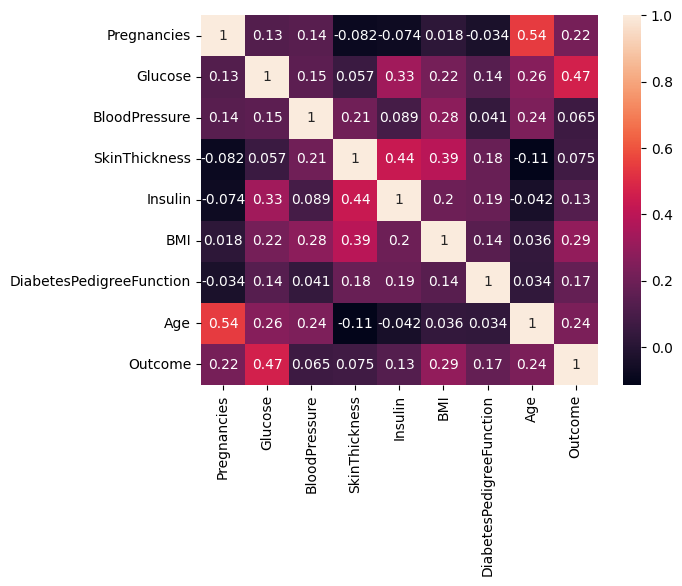

In [ ]:
corr = df.corr()
sns.heatmap(corr, annot=True)

The heatmap suggests a weak correlation between blood pressure and skin thickness, but our research revealed a possible connection based on publications from the National Library of Medicine of USA.

https://www.ncbi.nlm.nih.gov/books/NBK481900/#:~:text=Skin%20thickening%20is%20frequently%20observed,feet%20are%20most%20frequently%20involved.

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4317611/#:~:text=It%20has%20been%20observed%20that,hypertensives%20develop%20diabetes%5B12%5D.

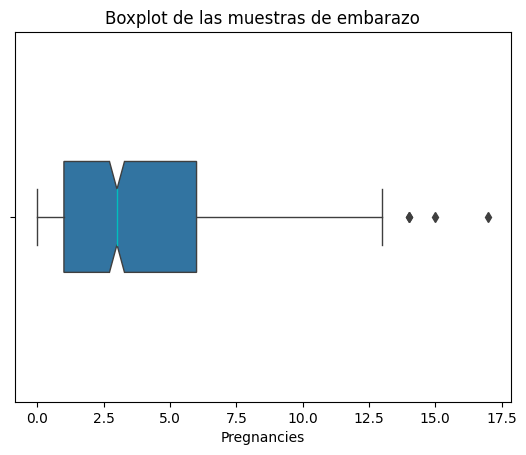

In [ ]:
sns.boxplot(x=df["Pregnancies"], data=df,notch = True,
            linewidth=1,
            medianprops={"color": "c", "linewidth": 1},
            width=0.3).set_title("Boxplot de las muestras de embarazo")

plt.show();

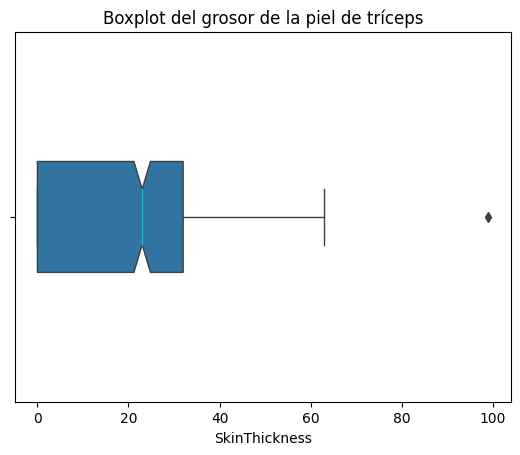

In [ ]:
sns.boxplot(x=df["SkinThickness"], data=df,notch = True,
            linewidth=1,
            medianprops={"color": "c", "linewidth": 1},
            width=0.3).set_title("Boxplot del grosor de la piel de tríceps")

plt.show();

##Correcciones: Drop, Replace

It is unusual to encounter people with 17 pregnancies and the records with these values are erroneous: 0 glucose, 0 blood pressure, 0 insulin and 0 bmi.

We will eliminate the records that have 0 and more than 12 pregnancies because they are not correlated with other columns so we cannot predict their value.

For the patients with 0 Skin Tickness, I decided to drop the column as it has 0 values for 30% of the cases. This is unrealistic. Using any technique to impute the values with, for example, the mean, might distort the rest of the data. We will run the models with the remaining columns.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9127233/#:~:text=In%20the%20study%20population%2C%20the,vs%2014.3%20%C2%B1%206.8%20mm).

In [ ]:
df['SkinThickness'].value_counts()

0     227
32     31
30     27
27     23
23     22
33     20
28     20
18     20
31     19
19     18
39     18
29     17
40     16
25     16
26     16
22     16
37     16
41     15
35     15
36     14
15     14
17     14
20     13
24     12
42     11
13     11
21     10
46      8
34      8
12      7
38      7
11      6
43      6
16      6
45      6
14      6
44      5
10      5
48      4
47      4
49      3
50      3
8       2
7       2
52      2
54      2
63      1
60      1
56      1
51      1
99      1
Name: SkinThickness, dtype: int64

In [ ]:
len(df[df['SkinThickness']==0.000000])

227

In [ ]:
len(df[df['BMI']==0.000000])

11

In [ ]:
len(df[df['Glucose']==0.000000])

5

In [ ]:
len(df[df['BloodPressure']==0.000000])

35

We replace the 0 values in the above columns with their respective means.


In [ ]:
selector = make_column_selector(dtype_include='number')
df_columns = selector(df)
means=[]
for i in df_columns:
  mean =df[{i}][df[{i}]!=0].mean()
  means.append(mean)

means


<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mean =df[{i}][df[{i}]!=0].mean()
<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mean =df[{i}][df[{i}]!=0].mean()
<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mean =df[{i}][df[{i}]!=0].mean()
<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mean =df[{i}][df[{i}]!=0].mean()
<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mean =df[{i}][df[{i}]!=0].mean()
<ipython-input-75-311afdb315f9>:5: FutureWarning: Passing a set as an indexer is depr

[Pregnancies    4.494673
 dtype: float64,
 Glucose    121.686763
 dtype: float64,
 BloodPressure    72.405184
 dtype: float64,
 SkinThickness    29.15342
 dtype: float64,
 Insulin    155.548223
 dtype: float64,
 BMI    32.457464
 dtype: float64,
 DiabetesPedigreeFunction    0.471876
 dtype: float64,
 Age    33.240885
 dtype: float64,
 Outcome    1.0
 dtype: float64]

In [ ]:
df['BMI'].replace(0,32.457464,inplace=True)
df['Glucose'].replace(0,121.686763,inplace=True)
df['BloodPressure'].replace(0,72.405184,inplace=True)
df.drop('SkinThickness',axis=1,inplace=True)
df['Insulin'].replace(0,155.548223,inplace=True)
df.drop(df[df['Pregnancies']>13].index, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 764 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               764 non-null    int64  
 1   Glucose                   764 non-null    float64
 2   BloodPressure             764 non-null    float64
 3   Insulin                   764 non-null    float64
 4   BMI                       764 non-null    float64
 5   DiabetesPedigreeFunction  764 non-null    float64
 6   Age                       764 non-null    int64  
 7   Outcome                   764 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 53.7 KB


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,3.786649,121.572557,72.415159,155.624983,32.433419,0.472260,33.187173,0.345550
std,3.278714,30.403014,12.120143,85.208192,6.882518,0.331619,11.764745,0.475859
min,0.000000,44.000000,24.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,122.000000,27.500000,0.244000,24.000000,0.000000
50%,3.000000,117.000000,72.405184,155.548223,32.400000,0.372500,29.000000,0.000000
75%,6.000000,140.000000,80.000000,155.548223,36.500000,0.626250,40.250000,1.000000
max,13.000000,199.000000,122.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Notes: No duplicate, missing, incorrect values, or outliers in the dataset.

Before we begin the processing, we will ensure the data is balanced.

In [ ]:
df['Outcome'].value_counts(normalize=True)

0    0.65445
1    0.34555
Name: Outcome, dtype: float64

The classes are imbalanced, which could bias the model towards the non-diabetic cases. Based on our research, we can use undersampling to balance the classes, as long as the difference between the two categories is less than 10%. We will undersample the dataset with the least amount of data removed from the train set as follows: 0: 55% and 1: 45%.

# **DATA PREPROCESSING**

Test & train split

I would rather have a test size of .25 instead of .30 as we undersampled the train dataset.

In [ ]:
X = df.drop(columns='Outcome')
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=42)

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, sampling_strategy=0.818)
X_train_rs, y_train_rs = rus.fit_resample(X_train, y_train)

In [ ]:
y_train_rs.value_counts(normalize=True)

0    0.549451
1    0.450549
Name: Outcome, dtype: float64

##Selectors, imputers, data encoders and scalers, column transformers & pipelines

In [ ]:
int_selector = make_column_selector(dtype_include='int')
float_selector = make_column_selector(dtype_include='float')

imputer_int= SimpleImputer(strategy='median')
imputer_float= SimpleImputer(strategy='mean')

scaler = StandardScaler()

preprocessor = make_column_transformer((make_pipeline(imputer_int, scaler), int_selector),
                             (make_pipeline(imputer_float, scaler), float_selector), remainder='passthrough')

pipeline = make_pipeline(preprocessor)

pipeline

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ec5bcc4aa10>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ec5bcc4a5c0>)]))])

##Fit and Transform

In [ ]:
pipeline.fit(X_train_rs)

X_train_processed = pipeline.transform(X_train_rs)
X_test_processed = pipeline.transform(X_test)

X_train_processed = pd.DataFrame(X_train_processed, columns=pipeline.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=pipeline.get_feature_names_out())

In [ ]:
X_train_processed.describe()

,pipeline-1__Pregnancies,pipeline-1__Age,pipeline-2__Glucose,pipeline-2__BloodPressure,pipeline-2__Insulin,pipeline-2__BMI,pipeline-2__DiabetesPedigreeFunction
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-1.561632e-17,-2.498612e-16,1.249306e-16,9.369794e-17,-3.279428e-16,6.246530e-17,1.873959e-16
std,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00,1.001101e+00
min,-1.171047e+00,-1.075550e+00,-2.183382e+00,-3.539156e+00,-1.576489e+00,-2.101576e+00,-1.177589e+00
25%,-8.698451e-01,-8.285568e-01,-7.504152e-01,-6.890226e-01,-3.681348e-01,-7.233015e-01,-7.125870e-01
50%,-2.674410e-01,-3.345712e-01,-9.906657e-02,-1.840301e-02,-1.447620e-02,-4.852120e-02,-3.017596e-01
75%,6.361653e-01,6.534000e-01,6.499843e-01,6.522166e-01,-1.447620e-02,5.760095e-01,5.003320e-01
max,2.744580e+00,3.864307e+00,2.441193e+00,3.167040e+00,7.604798e+00,4.919010e+00,5.850117e+00


In [ ]:
X_test_processed.describe()

,pipeline-1__Pregnancies,pipeline-1__Age,pipeline-2__Glucose,pipeline-2__BloodPressure,pipeline-2__Insulin,pipeline-2__BMI,pipeline-2__DiabetesPedigreeFunction
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,-0.011971,-0.107407,-0.026994,0.126464,0.000763,-0.071940,-0.056900
std,0.984190,0.961415,1.040413,0.992606,0.795809,0.972296,0.956511
min,-1.171047,-1.075550,-2.183382,-2.868536,-1.565454,-1.914935,-1.198658
25%,-0.869845,-0.828557,-0.782983,-0.605195,-0.158466,-0.744837,-0.685500
50%,-0.267441,-0.499233,-0.164201,0.015563,-0.014476,-0.054628,-0.383022
75%,0.636165,0.406407,0.649984,0.652217,-0.014476,0.439618,0.364894
max,2.744580,3.123328,2.408626,3.502350,3.565914,3.512022,4.998365


# **MODELS**

The task is a classification problem, and we will utilize Decision Tree, Bagging, Random Forest, KNN and Logistic Regression models

## Decision Tree

###Model

Standard model without optimization

In [ ]:
dectree = DecisionTreeClassifier()
dectree.fit(X_train_processed, y_train_rs)
dt_train_score = dectree.score(X_train_processed, y_train_rs)
dt_test_score = dectree.score(X_test_processed, y_test)
print(dt_train_score)
print(dt_test_score)

1.0
0.6596858638743456


There is a clear overtiffing issue in the standard model. The graph shows the relationship between the maximum depth of a decision tree classifier and its accuracy on the train and test sets.

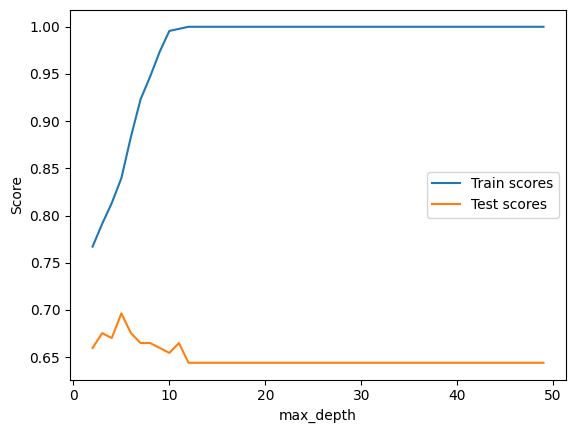

In [ ]:
import matplotlib.pyplot as plt

depth_range = list(range(2,50))

dt_test_scores = []
dt_train_scores = []
for depth in depth_range:
  dectree = DecisionTreeClassifier(max_depth=depth, random_state=42)
  dectree.fit(X_train_processed, y_train_rs)
  dt_train_score = dectree.score(X_train_processed, y_train_rs)
  dt_test_score = dectree.score(X_test_processed, y_test)
  dt_test_scores.append(dt_test_score)
  dt_train_scores.append(dt_train_score)



plt.plot(depth_range, dt_train_scores, label='Train scores')
plt.plot(depth_range, dt_test_scores, label='Test scores')
plt.xlabel('max_depth')
plt.ylabel('Score')
plt.legend()

As we can see, the train scores increase as the max_depth increases, reaching a perfect score of 1 at max_depth = 10. However, the test scores peak at max_depth = 4, and then decline as the max_depth increases further. This suggests that the classifier is overfitting the train data and generalizing poorly to the test data when the max_depth is too high.

We will use a max depth of 4 to optimize our results without overfitting too much the model.

In [ ]:
dectree = DecisionTreeClassifier(max_depth=4, random_state=42)
dectree.fit(X_train_processed, y_train_rs)
dt_train_score = dectree.score(X_train_processed, y_train_rs)
dt_test_score = dectree.score(X_test_processed, y_test)
print(dt_train_score)
print(dt_test_score)

0.8131868131868132
0.6701570680628273


###Report

In [ ]:
y_preds_dt = dectree.predict(X_test_processed)
dectree_clreport = classification_report(y_test, y_preds_dt)
print(dectree_clreport)

              precision    recall  f1-score   support

           0       0.89      0.60      0.71       132
           1       0.48      0.83      0.61        59

    accuracy                           0.67       191
   macro avg       0.68      0.71      0.66       191
weighted avg       0.76      0.67      0.68       191



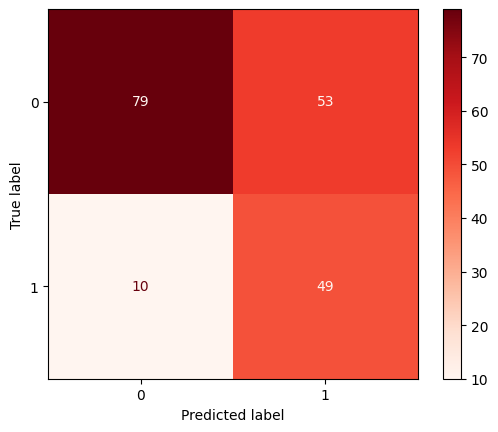

In [ ]:
ConfusionMatrixDisplay.from_estimator(dectree, X_test_processed, y_test, cmap = 'Reds');

Out model is failing to acurately predict postive cases

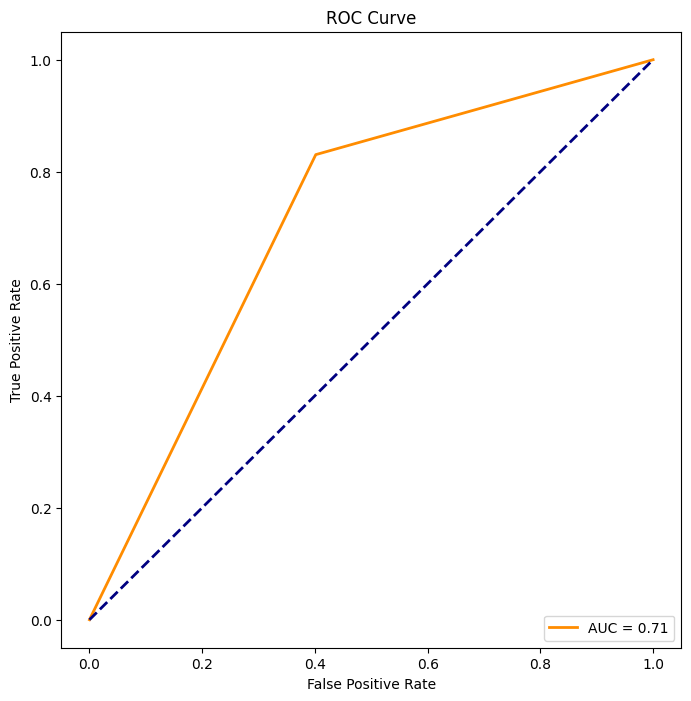

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_dt)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

My report uses precision, recall, and AUC as the evaluation metrics. It shows that the classifier has a high precision for the negative class (89%), but a low precision for the positive class (48%), which could lead to missing the diagnosis of diabetes for some patients. The report also shows that the classifier has a high recall for the positive class(83%), but a low recall for the negative class (60%), which could lead to overdiagnosis of diabetes for some patients. The report concludes that the classifier has a moderate AUC of 0.71, which could be improved by using a different algorithm, tuning the hyperparameters, or preprocessing the data. it also provides some references and examples of data science project reports for further reading.

##Bagging Classfifier

###Modelo

In [ ]:
bagcla = BaggingClassifier()
bagcla.fit(X_train_processed, y_train_rs)
bc_train_score = bagcla.score(X_train_processed, y_train_rs)
bc_test_score = bagcla.score(X_test_processed, y_test)
print(bc_train_score)
print(bc_test_score)

0.9802197802197802
0.7277486910994765


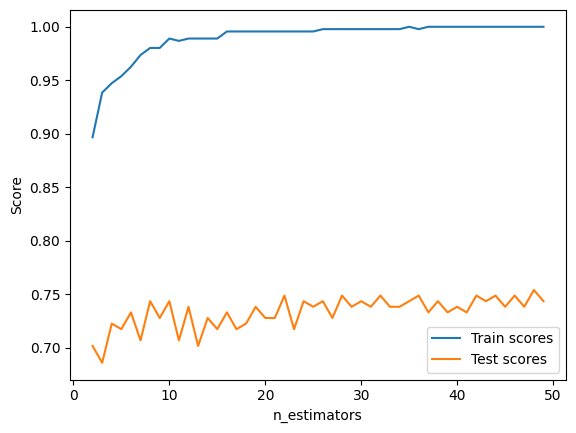

In [ ]:
import matplotlib.pyplot as plt

bc_n_estimators = list(range(2,50))

bc_test_scores = []
bc_train_scores = []
for estimat in bc_n_estimators:
  bagcla = BaggingClassifier(n_estimators=estimat, random_state=42)
  bagcla.fit(X_train_processed, y_train_rs)
  bc_train_score = bagcla.score(X_train_processed, y_train_rs)
  bc_test_score = bagcla.score(X_test_processed, y_test)
  bc_test_scores.append(bc_test_score)
  bc_train_scores.append(bc_train_score)

plt.plot(bc_n_estimators, bc_train_scores, label='Train scores')
plt.plot(bc_n_estimators, bc_test_scores, label='Test scores')
plt.xlabel('n_estimators')
plt.ylabel('Score')
plt.legend()

The model still shows overfitting even thought we compared both train and test sets in a n_estimators range between 2 and 50. The minimum accuracy score distance between both falls in a n_estimators of 47.

In [ ]:
bagcla = BaggingClassifier(n_estimators=47)
bagcla.fit(X_train_processed, y_train_rs)
bc_train_score = bagcla.score(X_train_processed, y_train_rs)
bc_test_score = bagcla.score(X_test_processed, y_test)
print(bc_train_score)
print(bc_test_score)

0.9956043956043956
0.7120418848167539


###Reporte

In [ ]:
y_preds_br = bagcla.predict(X_test_processed)
br_clreport = classification_report(y_test, y_preds_br)
print(br_clreport)

              precision    recall  f1-score   support

           0       0.87      0.68      0.77       132
           1       0.52      0.78      0.63        59

    accuracy                           0.71       191
   macro avg       0.70      0.73      0.70       191
weighted avg       0.77      0.71      0.72       191



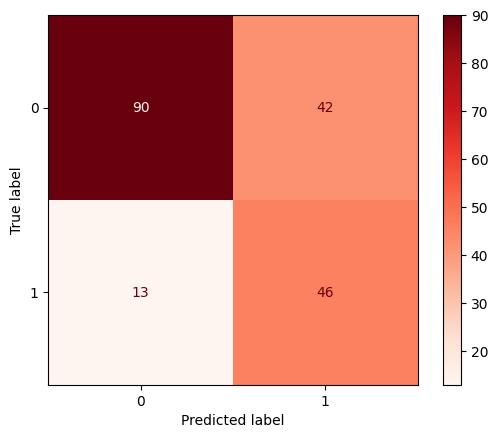

In [ ]:
ConfusionMatrixDisplay.from_estimator(bagcla, X_test_processed, y_test, cmap = 'Reds');

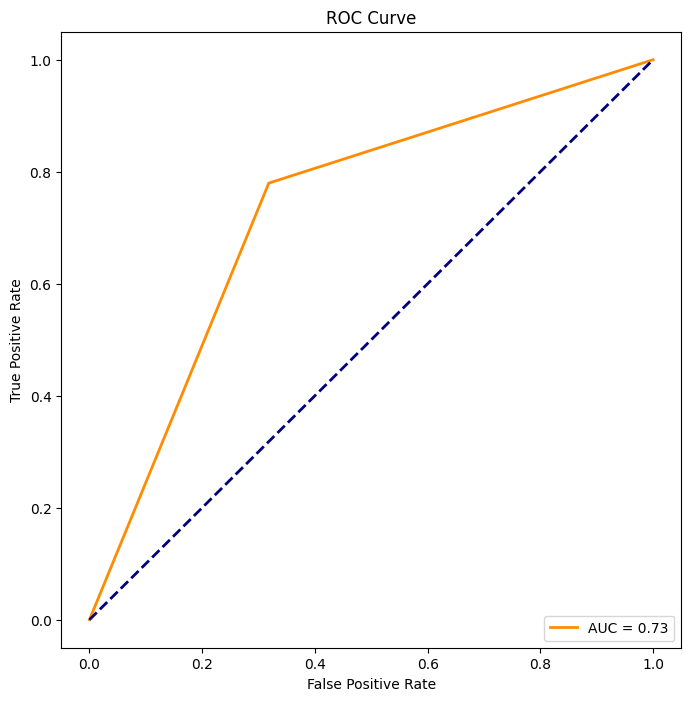

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_br)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The report evaluates the classifier using precision, recall, and AUC, which are metrics that measure how well the classifier can identify and distinguish the two classes. The report shows that the classifier has a perfect train score (1.0), but a lower test score (0.71), which indicates overfitting. The report also shows that the classifier has a high recall, but a low precision for the positive class, which means that it often misses the negative cases which could be a problem. The report concludes that the classifier has a moderate AUC of 0.73, which could be improved by using a different algorithm, tuning the hyperparameters, or preprocessing the data.

##Random Forest

###Modelo

In [ ]:
ranfor = RandomForestClassifier()
ranfor.fit(X_train_processed, y_train_rs)
rf_train_score = ranfor.score(X_train_processed, y_train_rs)
rf_test_score = ranfor.score(X_test_processed, y_test)
print(rf_train_score)
print(rf_test_score)

1.0
0.7225130890052356


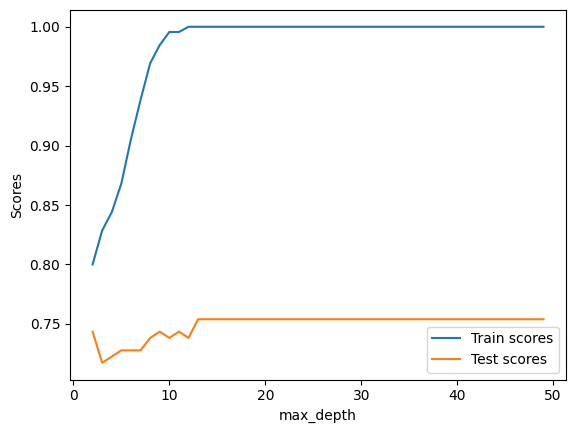

In [ ]:
import matplotlib.pyplot as plt

rf_depth = list(range(2,50))

rf_test_scores = []
rf_train_scores = []
for depth in bc_n_estimators:
  ranfor = RandomForestClassifier(max_depth=depth, random_state=42)
  ranfor.fit(X_train_processed, y_train_rs)
  rf_train_score = ranfor.score(X_train_processed, y_train_rs)
  rf_test_score = ranfor.score(X_test_processed, y_test)
  rf_test_scores.append(rf_test_score)
  rf_train_scores.append(rf_train_score)

plt.plot(rf_depth, rf_train_scores, label='Train scores')
plt.plot(rf_depth, rf_test_scores, label='Test scores')
plt.xlabel('max_depth')
plt.ylabel('Scores')
plt.legend()

In this graph is easy to identify our sweet spot. When the max depth of of decision tress is 2, the distance between our train score and test score is 0.05, minimizing our variance.

In [ ]:
ranfor = RandomForestClassifier(max_depth=2, random_state=42)
ranfor.fit(X_train_processed, y_train_rs)
rf_train_score = ranfor.score(X_train_processed, y_train_rs)
rf_test_score = ranfor.score(X_test_processed, y_test)
print(rf_train_score)
print(rf_test_score)

0.8
0.743455497382199


###Reporte

In [ ]:
y_preds_rf = ranfor.predict(X_test_processed)
rf_clreport = classification_report(y_test, y_preds_rf)
print(rf_clreport)

              precision    recall  f1-score   support

           0       0.87      0.73      0.80       132
           1       0.56      0.76      0.65        59

    accuracy                           0.74       191
   macro avg       0.72      0.75      0.72       191
weighted avg       0.78      0.74      0.75       191



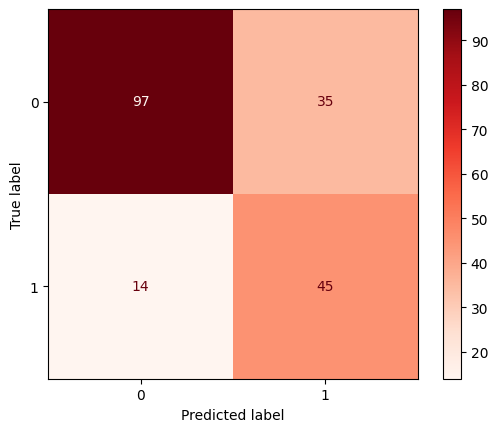

In [ ]:
ConfusionMatrixDisplay.from_estimator(ranfor, X_test_processed, y_test, cmap = 'Reds');

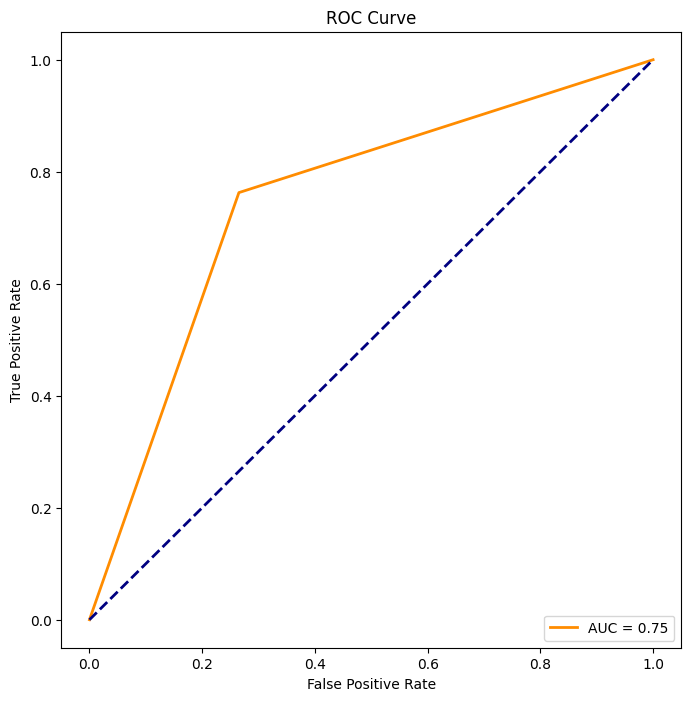

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_rf)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

This report shows that the classifier is barely overfitting the train data (train score: 0.8, test score: 0.74) which is a good thing, and has low precision for the positive class (0.56), which could lead to missing the diagnosis of diabetes. It also shows that the classifier has high recall for the positive class (0.76), but low recall for the negative class (0.73), which could lead to overdiagnosis of diabetes. The report concludes that the classifier has an AUC of 0.64, which is letting us know that it is nor performing well and should be fine tunned using other hyperparameters or use another models.

## KNN

###Modelo

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train_processed, y_train_rs)
knn_train_score = knn.score(X_train_processed, y_train_rs)
knn_test_score = knn.score(X_test_processed, y_test)
print(knn_train_score)
print(knn_test_score)

0.8043956043956044
0.7486910994764397


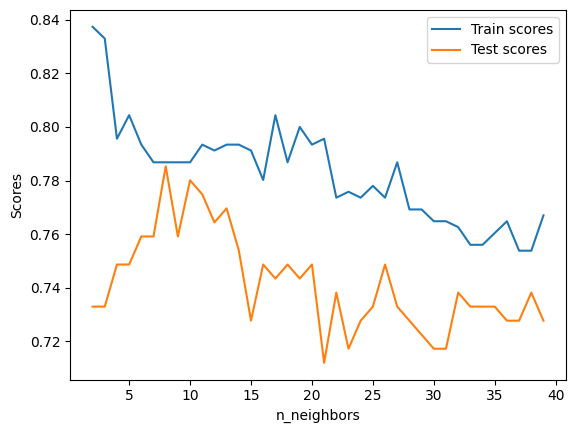

In [ ]:
import matplotlib.pyplot as plt

max_neighbors_range = list(range(2,40))

list_test_scores = []
list_train_scores = []
for neighbors in max_neighbors_range:
  knn = KNeighborsClassifier(n_neighbors=neighbors)
  knn.fit(X_train_processed, y_train_rs)
  knn_train_score = knn.score(X_train_processed, y_train_rs)
  knn_test_score = knn.score(X_test_processed, y_test)
  list_test_scores.append(knn_test_score)
  list_train_scores.append(knn_train_score)

plt.plot(max_neighbors_range, list_train_scores, label='Train scores')
plt.plot(max_neighbors_range, list_test_scores, label='Test scores')
plt.xlabel('n_neighbors')
plt.ylabel('Scores')
plt.legend()

In this case, the train and test sets achieved high accuracy scores. The test scores reached their max at n_neighbors = 8, which also minimized the gap with the train score.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train_processed, y_train_rs)
knn_train_score = knn.score(X_train_processed, y_train_rs)
knn_test_score = knn.score(X_test_processed, y_test)
print(knn_train_score)
print(knn_test_score)

0.7868131868131868
0.7853403141361257


###Reporte

In [ ]:
y_preds_knn = knn.predict(X_test_processed)
knn_clreport = classification_report(y_test, y_preds_knn)
print(knn_clreport)

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       132
           1       0.63      0.73      0.68        59

    accuracy                           0.79       191
   macro avg       0.75      0.77      0.76       191
weighted avg       0.80      0.79      0.79       191



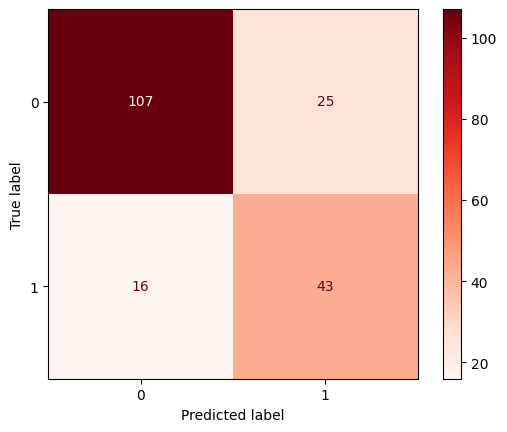

In [ ]:
ConfusionMatrixDisplay.from_estimator(knn, X_test_processed, y_test, cmap = 'Reds');

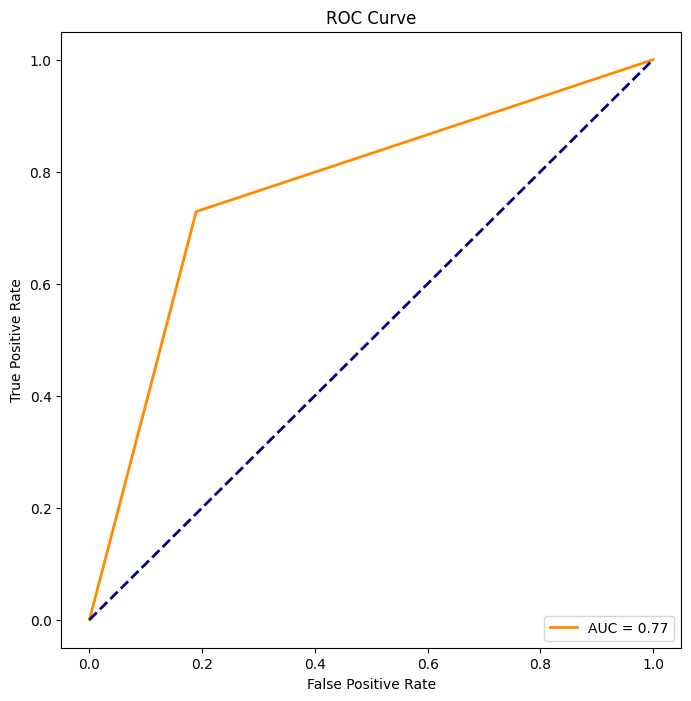

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_knn)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

This report shows that the classifier has a good and consistent accuracy on both the train and test sets (0.78). However, the report also shows that the classifier has low precision for the positive class (0.63), which could lead to missing the diagnosis of diabetes, and low recall for the negative class (0.81), which could lead to overdiagnosis of diabetes. It's of AUC: 0.77 is letting us know that it has a moderate ability to classify correctly both classes. We are going to analize one more model next but this is the model that has the best performance so far.

##Logistic Regression

###Modelo

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train_processed, y_train_rs)
lg_train_score = logreg.score(X_train_processed, y_train_rs)
lg_test_score = logreg.score(X_test_processed, y_test)
print(lg_train_score)
print(lg_test_score)

0.7648351648351648
0.7486910994764397


{0.0001: 0.6910994764397905,
 0.001: 0.6910994764397905,
 0.01: 0.7486910994764397,
 0.1: 0.7486910994764397,
 1: 0.7486910994764397,
 10: 0.7486910994764397,
 100: 0.7486910994764397,
 1000: 0.7486910994764397}

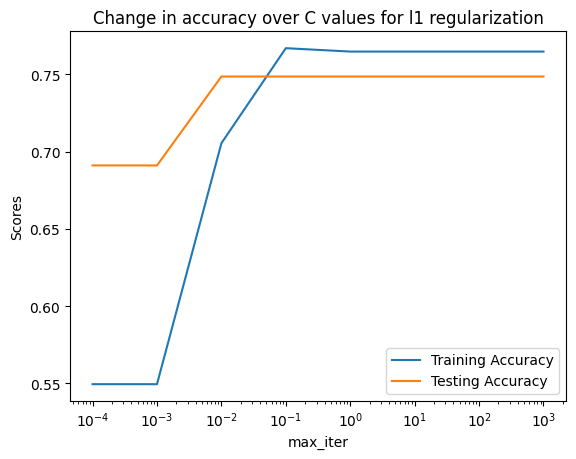

In [ ]:

c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lg1_train_scores = []
lg1_test_scores = []

for c in c_values:

  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l1')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train_processed, y_train_rs)
  lg1_train_scores.append(log_reg_pipe.score(X_train_processed, y_train_rs))
  lg1_test_scores.append(log_reg_pipe.score(X_test_processed, y_test))


fig, ax = plt.subplots(1,1)
ax.plot(c_values, lg1_train_scores, label='Training Accuracy')
ax.plot(c_values, lg1_test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l1 regularization')
ax.legend()
plt.xlabel('max_iter')
plt.ylabel('Scores')

ax.set_xscale('log')
{c:score for c, score in zip(c_values, lg1_test_scores)}

{0.0001: 0.7329842931937173,
 0.001: 0.7382198952879581,
 0.01: 0.7539267015706806,
 0.1: 0.7539267015706806,
 1: 0.7486910994764397,
 10: 0.7486910994764397,
 100: 0.7486910994764397,
 1000: 0.7486910994764397}

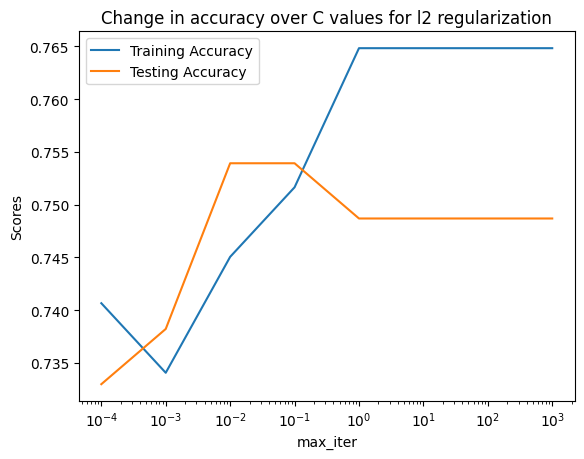

In [ ]:
c_values = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
lg1_train_scores = []
lg1_test_scores = []

for c in c_values:
  log_reg = LogisticRegression(C=c, max_iter=1000, solver='liblinear', penalty='l2')
  log_reg_pipe = make_pipeline(scaler, log_reg)
  log_reg_pipe.fit(X_train_processed, y_train_rs)
  lg1_train_scores.append(log_reg_pipe.score(X_train_processed, y_train_rs))
  lg1_test_scores.append(log_reg_pipe.score(X_test_processed, y_test))

fig, ax = plt.subplots(1,1)
ax.plot(c_values, lg1_train_scores, label='Training Accuracy')
ax.plot(c_values, lg1_test_scores, label='Testing Accuracy')
ax.set_xticks(c_values)
ax.set_title('Change in accuracy over C values for l2 regularization')
ax.legend()
plt.xlabel('max_iter')
plt.ylabel('Scores')

ax.set_xscale('log')
{c:score for c, score in zip(c_values, lg1_test_scores)}

I tested our logistic regresion models in two parts, different penalizations: l1 & l2. After analizing the graphs I concluded that the best hyperparameters for this model are:

C: 0.01 /

Mejor: L1 /

Score test: 0.76

In [ ]:
logreg = LogisticRegression(C=0.1, max_iter=1000, solver='liblinear', penalty='l1')
logreg.fit(X_train_processed, y_train_rs)
lg_train_score = logreg.score(X_train_processed, y_train_rs)
lg_test_score = logreg.score(X_test_processed, y_test)
print(lg_train_score)
print(lg_test_score)

0.7670329670329671
0.7486910994764397


###Reporte

In [ ]:
y_preds_lg = logreg.predict(X_test_processed)
lg_clreport = classification_report(y_test, y_preds_lg)
print(lg_clreport)

              precision    recall  f1-score   support

           0       0.86      0.77      0.81       132
           1       0.58      0.71      0.64        59

    accuracy                           0.75       191
   macro avg       0.72      0.74      0.72       191
weighted avg       0.77      0.75      0.75       191



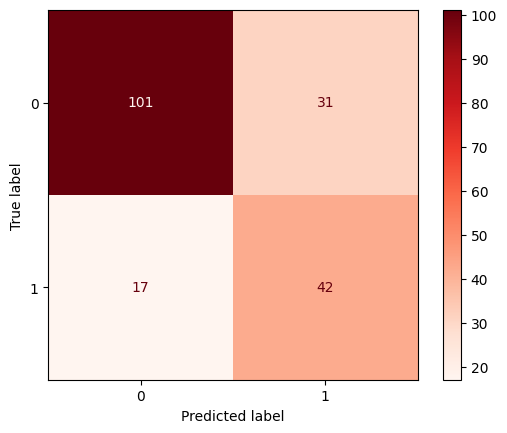

In [ ]:
ConfusionMatrixDisplay.from_estimator(logreg, X_test_processed, y_test, cmap = 'Reds');

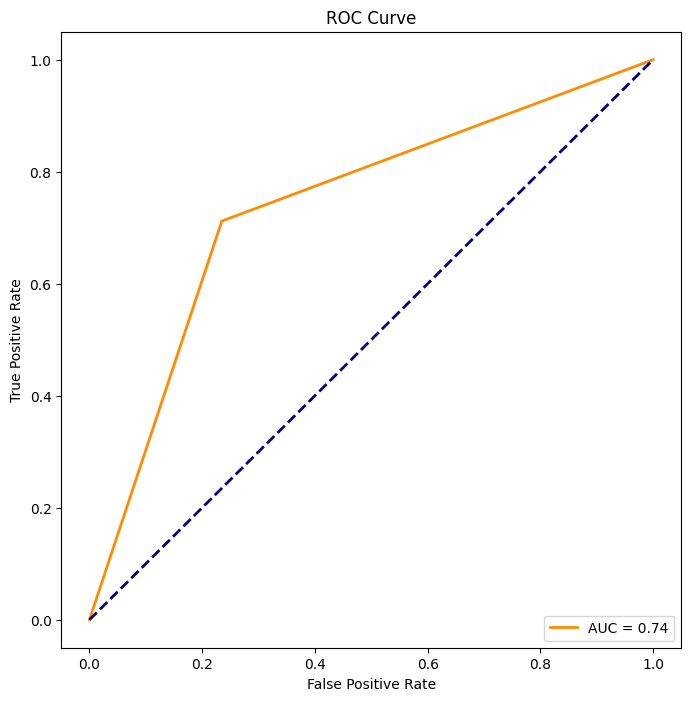

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_preds_lg)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The report shows that the classifier has a good and consistent accuracy on both the train and test sets (0.76 and 0.74). However, the report also shows that the classifier has low precision for the positive class (0.58), which could lead to missing the diagnosis of diabetes, and low recall for the negative class (0.77), which could lead to overdiagnosis of diabetes. The report concludes that the classifier has a moderate ability to separate the two classes (AUC: 0.74). As we can see, althought it had moderate results, they were not as good as the knn classificator.

# **CONCLUSION**

We applied different classification models to predict whether a person has diabetes or not, based on various features such as age, blood pressure, glucose level, etc. We labeled the cases with diabetes as 1 and the cases without diabetes as 0. We used the accuracy score, the f1 score, and the area under the ROC curve (AUC) as the evaluation metrics for our models. We also checked for overfitting by comparing the training and test scores.

Among the models that we tried, the best one was KNeighborsClassifier(n_neighbors=8). This model achieved an accuracy score of 78% on both the training and test sets, indicating that it did not overfit the data. The f1 score for the positive class (1) was 0.84, and the f1 score for the negative class (0) was 0.68, both higher than the other models. The AUC of this model was 0.77, which means that it had a good trade-off between sensitivity and specificity.

Based on these results, we can conclude that KNeighborsClassifier(n_neighbors=8) is a suitable model for predicting diabetes status from the given features.